## Feature Extraction and Selection

This notebook performs feature extraction and selection for EEG error potential (ErrP) classification.

Steps:

1. Loads raw and preprocessed EEG epochs, labels, and metadata (subjects, sessions, trials).
2. Visualizes the temporal profiles of error (ErrP) and correct (ERP) trials, including average responses and variability across trials.
3. Quantifies the discriminative power of features (channels and spatial filters) using the r² statistic, both on raw and spatially filtered data.
4. Applies the Fisher Criterion Beamformer (FCB) for statistical spatial filtering, projecting EEG epochs onto components that maximize error/correct class separation.
5. Visualizes spatial filter projections, their discrimination power, and the weights of spatial filters across EEG channels.
6. Determines the minimal number of spatial components required to explain the majority of class-discriminative variance (e.g., 80% of total mean r²).
7. Ranks channels by their contribution to the top FCB components.
8. Prepares, formats, and saves all feature and metadata arrays (including projections, labels, subjects, sessions, and trials) to disk for reproducibility and use in classification experiments.

All computations and visualizations use functions from bci_utils.py.

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import bci_utils
import pandas as pd

In [2]:
# Load preprocessed output data from data_preprocessing_aggregation.ipynb
all_epochs = np.load("/Users/Rosie/Documents/Applications/HRC_BCI_VU/Casus_BCI_classifier/data_preprocessed/all_epochs.npy") 
all_labels = np.load("/Users/Rosie/Documents/Applications/HRC_BCI_VU/Casus_BCI_classifier/data_preprocessed/all_labels.npy") 
all_subjects = np.load("/Users/Rosie/Documents/Applications/HRC_BCI_VU/Casus_BCI_classifier/data_preprocessed/all_subjects.npy") 
all_sessions = np.load("/Users/Rosie/Documents/Applications/HRC_BCI_VU/Casus_BCI_classifier/data_preprocessed/all_sessions.npy") 
all_trials = np.load("/Users/Rosie/Documents/Applications/HRC_BCI_VU/Casus_BCI_classifier/data_preprocessed/all_trials.npy") 

In [3]:
# Correct and error masks
error_mask = all_labels == 1
correct_mask = all_labels == 0

# Split arrays
error_epochs = all_epochs[error_mask]
correct_epochs = all_epochs[correct_mask]

print('Error epochs shape:', error_epochs.shape)
print('Correct epochs shape:', correct_epochs.shape)

Error epochs shape: (1322, 200, 64)
Correct epochs shape: (5115, 200, 64)


In [4]:
error_epochs = np.transpose(error_epochs, (2, 1, 0))
correct_epochs = np.transpose(correct_epochs, (2, 1, 0))

# X-axis in milliseconds:
t_ms = np.linspace(200, 600, 200)  # In ms

# A well-working time-window discovered too late
#t_ms = np.linspace(300, 800, 307)  # In ms

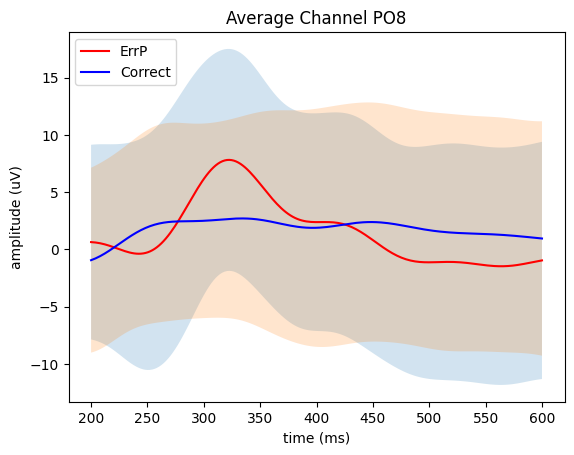

In [5]:
# Average of data (targets (ErrPs) and non-targets (Correct ERPs))
error_mean = np.mean(error_epochs, axis=2) 
error_std  = np.std(error_epochs,axis=2);
correct_mean = np.mean(correct_epochs,axis=2)
correct_std  = np.std(correct_epochs,axis=2)

# Plot average
ch = 47  # channel PO8
plt.plot(t_ms, error_mean[ch, :], 'r', label = 'ErrP')
plt.plot(t_ms, correct_mean[ch, :], 'b', label = 'Correct')

plt.xlabel('time (ms)')
plt.ylabel('amplitude (uV)')

plt.title('Average Channel PO8')
plt.legend(loc = 'upper left')

plt.fill_between(t_ms, error_mean[ch, :] + error_std[ch, :], error_mean[ch, :] - error_std[ch,:], alpha=0.2)
plt.fill_between(t_ms, correct_mean[ch, :] + correct_std[ch, :], correct_mean[ch, :] - correct_std[ch,:], alpha=0.2)
plt.show()

### R-square discrimination of data without spatial filtering

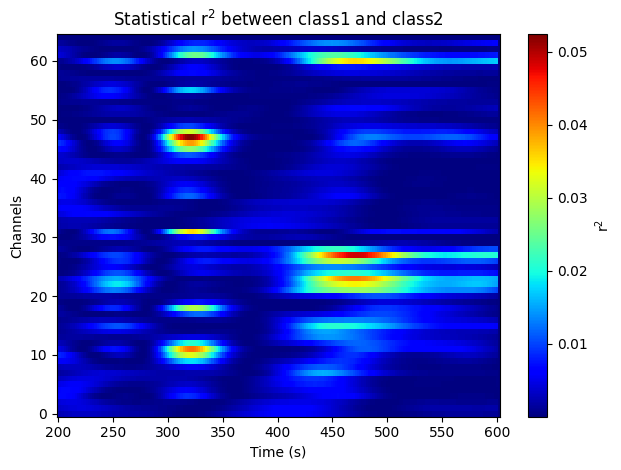

In [6]:
# Analysis of feature discrimination with r-square of raw data
N_ch = np.size(error_epochs, 0);              # channels
N_samp = np.size(error_epochs, 1);            # time samples
rsq = np.zeros((N_samp, N_ch));     # initialize variable

for ch in np.arange(N_ch):
    for samp in np.arange(N_samp):
        rsq[samp, ch] = bci_utils.rsquare(error_epochs[ch, samp,:], correct_epochs[ch, samp,:])

bci_utils.plot_rsquare(t_ms, rsq)
del rsq

### Applying FCB to ErrP dataset

In [7]:
# Obtaining FCB statistical spatial filters
U, V = bci_utils.FCB_spatial_filters(error_epochs, correct_epochs, 0.1)

# Projections obtained from spatial filters
error_epochs_proj , correct_epochs_proj = bci_utils.FCB_projections(error_epochs, correct_epochs, U)

# Average of data (targets and non-targets)
error_epochs_proj_mean = np.mean(error_epochs_proj, axis=2) 
error_epochs_proj_std  = np.std(error_epochs_proj, axis=2);
correct_epochs_proj_mean = np.mean(correct_epochs_proj, axis=2);
correct_epochs_proj_std  = np.std(correct_epochs_proj, axis=2);

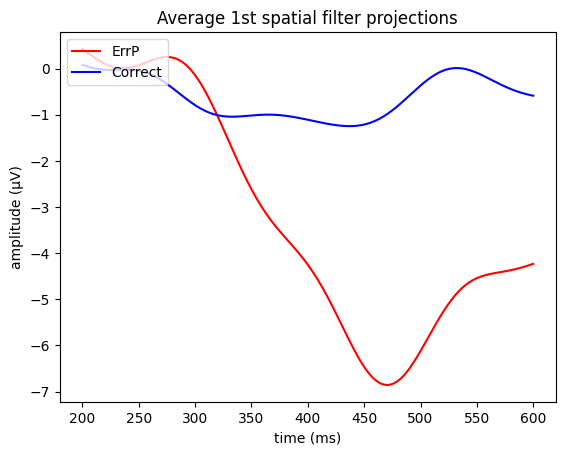

In [8]:
# Plotting spatially filtered data
plt.plot(t_ms, error_epochs_proj_mean[0, :], 'r', label='ErrP')
plt.plot(t_ms, correct_epochs_proj_mean[0, :], 'b', label='Correct')
plt.xlabel('time (ms)')
plt.ylabel('amplitude (µV)')
plt.title('Average 1st spatial filter projections')
plt.legend(loc = 'upper left')
plt.show()

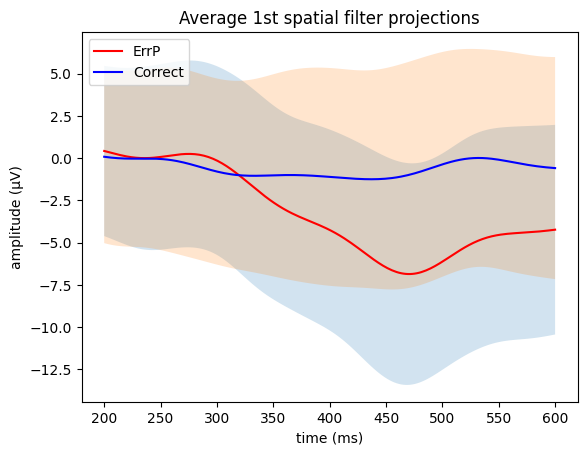

In [9]:
# Plotting spatially filtered data with standard deviation
plt.plot(t_ms, error_epochs_proj_mean[0, :], 'r', label = 'ErrP')
plt.plot(t_ms, correct_epochs_proj_mean[0, :], 'b', label = 'Correct')
plt.xlabel('time (ms)')
plt.ylabel('amplitude (µV)')
plt.title('Average 1st spatial filter projections')
plt.legend(loc = 'upper left')
plt.fill_between(t_ms, error_epochs_proj_mean[0, :] + error_epochs_proj_std[0, :], error_epochs_proj_mean[0, :] - error_epochs_proj_std[0, :], alpha=0.2)
plt.fill_between(t_ms, correct_epochs_proj_mean[0, :] + correct_epochs_proj_std[0, :], correct_epochs_proj_mean[0, :] - correct_epochs_proj_std[0, :], alpha=0.2)
plt.show()

### R-square discrimination of spatially filtered data

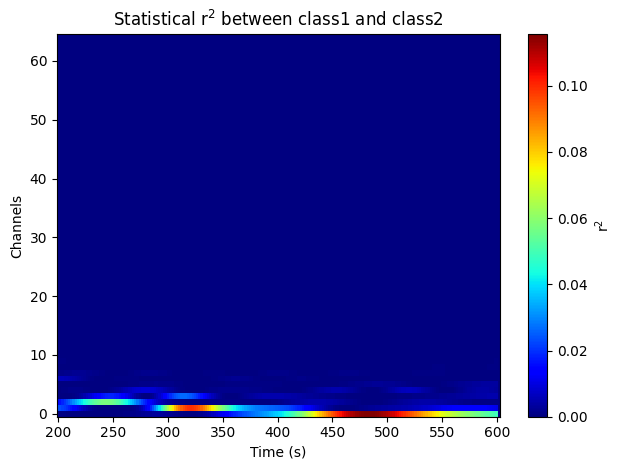

In [10]:
# Analysis of feature discrimination with r-square of spatially filtered data
N_ch = np.size(error_epochs_proj, 0);      
N_samp = np.size(error_epochs_proj, 1);        
rsq = np.zeros((N_samp, N_ch));             

for ch in np.arange(N_ch):
    for samp in np.arange(N_samp):
        rsq[samp, ch] = bci_utils.rsquare(error_epochs_proj[ch, samp,:], correct_epochs_proj[ch, samp,:])

bci_utils.plot_rsquare(t_ms, rsq)

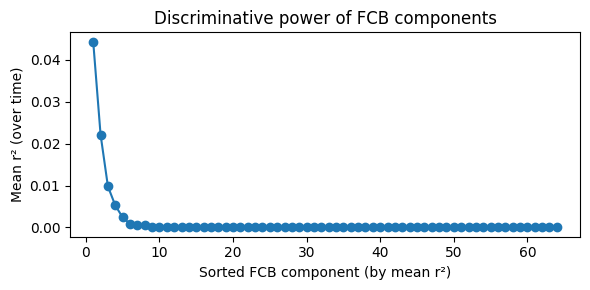

In [11]:
mean_rsq_per_comp = np.mean(rsq, axis=0)  # shape: (n_components,)
sorted_indices = np.argsort(mean_rsq_per_comp)[::-1]  # Descending order

plt.figure(figsize=(6, 3))
plt.plot(np.arange(1, len(mean_rsq_per_comp)+1), mean_rsq_per_comp[sorted_indices], marker='o')
plt.xlabel('Sorted FCB component (by mean r²)')
plt.ylabel('Mean r² (over time)')
plt.title('Discriminative power of FCB components')
plt.tight_layout()
plt.show()

In [12]:
cumsum = np.cumsum(mean_rsq_per_comp[sorted_indices])
cumsum /= cumsum[-1]  # Normalize to 1
n_80 = np.where(cumsum > 0.8)[0][0] + 1
print(f"Number of components to reach 80% of total mean r²: {n_80}")

Number of components to reach 80% of total mean r²: 3


### Component - Channel Matching

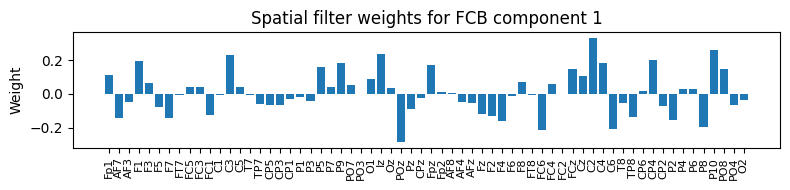

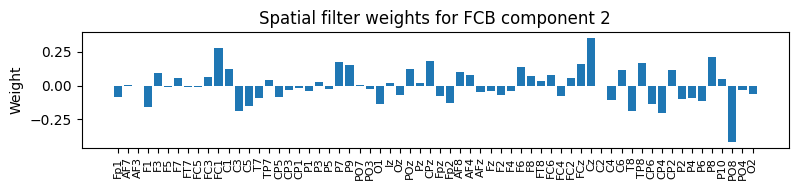

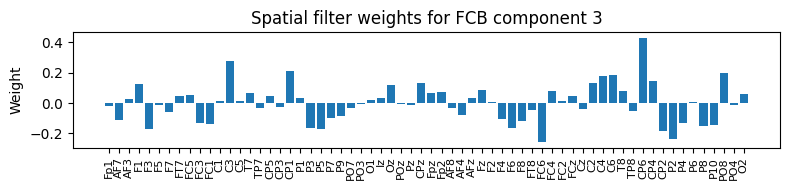

In [13]:
# U shape: (n_channels, n_components)

ch_names = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3',
            'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3',
            'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2',
            'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8',
            'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

# Plot the weights of first 3 FCB components (r^2 > 80%) across channels
for comp in range(3):
    plt.figure(figsize=(8,2))
    plt.bar(range(len(ch_names)), U[:, comp])
    plt.xticks(range(len(ch_names)), ch_names, rotation=90, fontsize=8)
    plt.title(f"Spatial filter weights for FCB component {comp+1}")
    plt.ylabel('Weight')
    plt.tight_layout()
    plt.show()

In [14]:
# U: (n_channels, n_components)
# ch_names: your list of channel names
n_top_components = 3  

# Compute the mean absolute weight of each channel across the top N components
mean_abs_weights = np.mean(np.abs(U[:, :n_top_components]), axis=1)

# Get channel ranking
sorted_indices = np.argsort(mean_abs_weights)[::-1]  # descending order
sorted_channels = [ch_names[i] for i in sorted_indices]
sorted_weights = mean_abs_weights[sorted_indices]

# Print top N channels
n_top_channels = 10
for i in range(n_top_channels):
    print(f"{sorted_channels[i]}: {sorted_weights[i]:.3f}")

PO8: 0.256
C3: 0.232
CP6: 0.196
P8: 0.187
CP4: 0.183
FC6: 0.182
FC1: 0.181
C6: 0.171
Cz: 0.165
P2: 0.165


### Save new features

In [50]:
# Original: (n_proj_channels, n_times, n_epochs)
error_epochs_proj = np.transpose(error_epochs_proj, (2, 1, 0))   # → (n_epochs, n_times, n_proj_channels)
correct_epochs_proj = np.transpose(correct_epochs_proj, (2, 1, 0))

all_epochs_proj = np.concatenate([error_epochs_proj, correct_epochs_proj], axis=0)
all_labels_proj = np.concatenate([np.ones(error_epochs_proj.shape[0]), np.zeros(correct_epochs_proj.shape[0])])

np.save("/Users/Rosie/Documents/Applications/HRC_BCI_VU/Casus_BCI_classifier/data_preprocessed/all_epochs_proj.npy", all_epochs_proj) 
np.save("/Users/Rosie/Documents/Applications/HRC_BCI_VU/Casus_BCI_classifier/data_preprocessed/all_labels_proj.npy", all_labels_proj) 

In [51]:
# Split metadata arrays
error_subjects = all_subjects[error_mask]
correct_subjects = all_subjects[correct_mask]

error_sessions = all_sessions[error_mask]
correct_sessions = all_sessions[correct_mask]

error_trials = all_trials[error_mask]
correct_trials = all_trials[correct_mask]

all_subjects_proj = np.concatenate([error_subjects, correct_subjects])
all_sessions_proj = np.concatenate([error_sessions, correct_sessions])
all_trials_proj = np.concatenate([error_trials, correct_trials])

In [52]:
np.save("/Users/Rosie/Documents/Applications/HRC_BCI_VU/Casus_BCI_classifier/data_preprocessed/all_subjects_proj.npy", all_subjects_proj) 
np.save("/Users/Rosie/Documents/Applications/HRC_BCI_VU/Casus_BCI_classifier/data_preprocessed/all_sessions_proj.npy", all_sessions_proj)
np.save("/Users/Rosie/Documents/Applications/HRC_BCI_VU/Casus_BCI_classifier/data_preprocessed/all_trials_proj.npy", all_trials_proj)